In [1]:
# Importar librerías necesarias
import json
import requests
import os
import zipfile
import geopandas as gpd 
import pandas as pd
import contextily as cx
import numpy as np
import io
from pandas import json_normalize
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt


In [2]:
# Leer archivo shape de los AGEBS de Nuevo León y transformar CRS
gdf = gpd.read_file("DF_FINAL.shp").to_crs(4326)

In [3]:
# Mostrar las primeras filas del GeoDataFrame
gdf.head()


CVEMA  MUN  NOM_MUN  AGEB  P12A14NOA  P15YM_AN  P18YM_PB  P6A11_NOAM  \
0  0061882    6  Apodaca  1882         10        67      3404           0   
1  0061435    6  Apodaca  1435          5        16      4582           4   
2  0061647    6  Apodaca  1647          3         6      2822           0   
3  0060969    6  Apodaca  0969          0         0         0           0   
4  006030A    6  Apodaca  030A         10        15      2860           7   

   POBTOT  PSINDER  ...  VPH_REFRI  VPH_TELEF  Restaurant  Restaura_1  \
0   10712     2186  ...       2786       1874           0           2   
1    9224     1185  ...       2538       1712           0           0   
2    4650      638  ...       1404       1128           0           0   
3       0        0  ...          0          0           8           2   
4    8268     1230  ...       2168       1343           0           1   

   Restaura_2  Restaura_3  Restaura_4  Restaura_5  Restaura_6  \
0           0           3           3           1           3   
1           0           1           1           3           0   
2           0           2           1           0           0   
3           1           3           3           6           0   
4           0           1           0           0           0   

                                            geometry  
0  POLYGON ((-100.15091 25.71505, -100.15099 25.7...  
1  POLYGON ((-100.16946 25.75323, -100.16861 25.7...  
2  POLYGON ((-100.23345 25.77729, -100.23349 25.7...  
3  POLYGON ((-100.18562 25.77552, -100.18542 25.7...  
4  POLYGON ((-100.16562 25.73954, -100.16554 25.7...  

[5 rows x 25 columns]

In [4]:
# Renombrar columnas
nuevos_nombres = {'Restaurant': 'Rest_Carta',
                  'Restaura_1': 'Rest_Antojitos',
                  'Restaura_2': 'Rest_Mariscos',
                  'Restaura_3': 'Rest_Rapida',
                  'Restaura_4': 'Rest_TacosTortas',
                  'Restaura_5': 'Rest_Autoserv',
                  'Restaura_6': 'Rest_OtrosLlevar',
                  }
gdf.rename(columns=nuevos_nombres, inplace=True)
gdf.head()

CVEMA  MUN  NOM_MUN  AGEB  P12A14NOA  P15YM_AN  P18YM_PB  P6A11_NOAM  \
0  0061882    6  Apodaca  1882         10        67      3404           0   
1  0061435    6  Apodaca  1435          5        16      4582           4   
2  0061647    6  Apodaca  1647          3         6      2822           0   
3  0060969    6  Apodaca  0969          0         0         0           0   
4  006030A    6  Apodaca  030A         10        15      2860           7   

   POBTOT  PSINDER  ...  VPH_REFRI  VPH_TELEF  Rest_Carta  Rest_Antojitos  \
0   10712     2186  ...       2786       1874           0               2   
1    9224     1185  ...       2538       1712           0               0   
2    4650      638  ...       1404       1128           0               0   
3       0        0  ...          0          0           8               2   
4    8268     1230  ...       2168       1343           0               1   

   Rest_Mariscos  Rest_Rapida  Rest_TacosTortas  Rest_Autoserv  \
0              0            3                 3              1   
1              0            1                 1              3   
2              0            2                 1              0   
3              1            3                 3              6   
4              0            1                 0              0   

   Rest_OtrosLlevar                                           geometry  
0                 3  POLYGON ((-100.15091 25.71505, -100.15099 25.7...  
1                 0  POLYGON ((-100.16946 25.75323, -100.16861 25.7...  
2                 0  POLYGON ((-100.23345 25.77729, -100.23349 25.7...  
3                 0  POLYGON ((-100.18562 25.77552, -100.18542 25.7...  
4                 0  POLYGON ((-100.16562 25.73954, -100.16554 25.7...  

[5 rows x 25 columns]

In [5]:
# Seleccionar columnas relevantes para clustering
columnas_clustering = ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar',
                       ]
datos_clustering = gdf[columnas_clustering]

In [6]:
# Normalizar los datos
scaler = StandardScaler()
datos_normalizados = scaler.fit_transform(datos_clustering)

In [7]:
# Realizar clustering jerárquico
Z = linkage(datos_normalizados, method='ward')

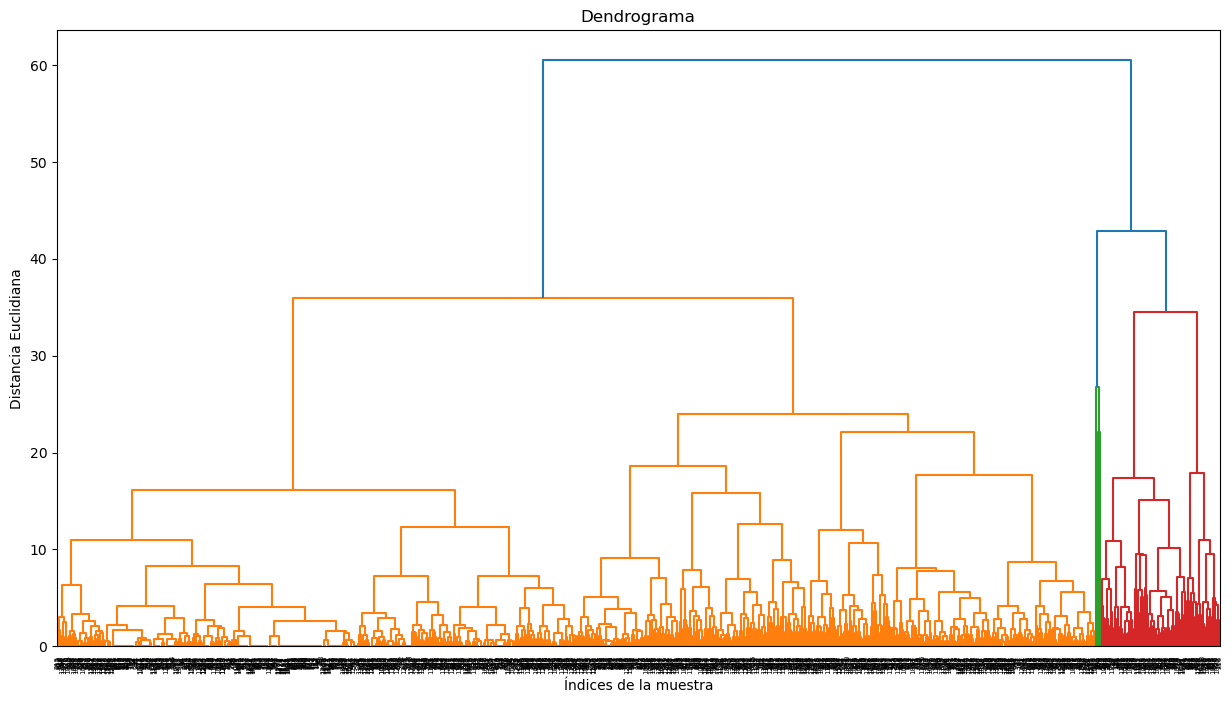

In [8]:
# Graficar dendrograma
plt.figure(figsize=(15, 8))
dendrogram(Z)
plt.title('Dendrograma')
plt.xlabel('Índices de la muestra')
plt.ylabel('Distancia Euclidiana')
plt.show()


In [9]:
# Definir número de clusters
num_clusters = 3

In [10]:
# Obtener etiquetas de clusters
clusters = fcluster(Z, num_clusters, criterion='maxclust')

In [11]:
# Agregar etiquetas de clustering al GeoDataFrame original
gdf['Cluster'] = clusters


In [12]:
# Distribución de los clusters
print(gdf['Cluster'].value_counts())

Cluster
1    1150
3     131
2       6
Name: count, dtype: int64


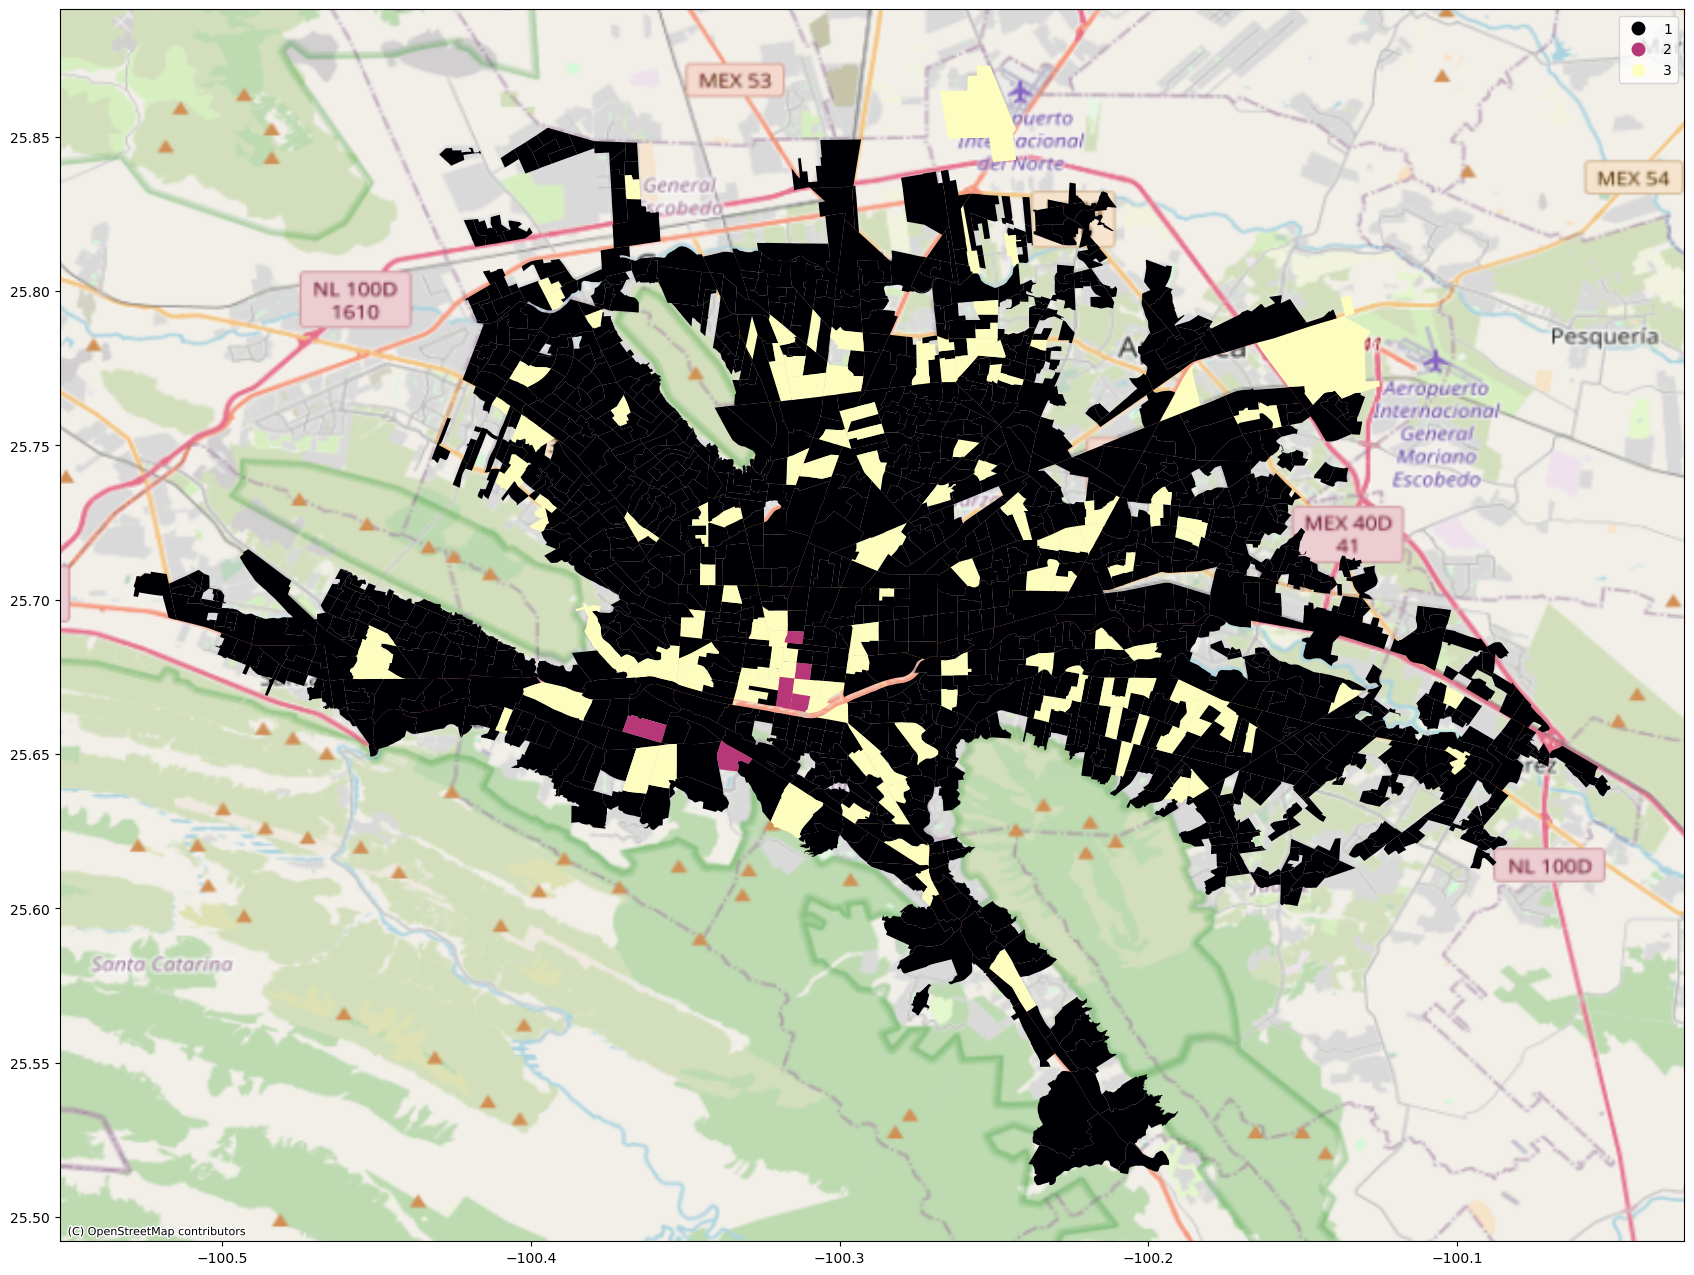

In [13]:
ax = gdf.plot("Cluster", cmap="magma", legend=True, figsize=(28, 16), categorical=True)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

In [16]:
total_restaurantes = ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar',
                       ]

gdf['Tot_Rest'] = gdf[total_restaurantes].sum(axis=1)

gdf['POBREST'] = gdf['POBTOT'] / gdf['Tot_Rest'] 
gdf.head()

CVEMA  MUN  NOM_MUN  AGEB  P12A14NOA  P15YM_AN  P18YM_PB  P6A11_NOAM  \
0  0061882    6  Apodaca  1882         10        67      3404           0   
1  0061435    6  Apodaca  1435          5        16      4582           4   
2  0061647    6  Apodaca  1647          3         6      2822           0   
3  0060969    6  Apodaca  0969          0         0         0           0   
4  006030A    6  Apodaca  030A         10        15      2860           7   

   POBTOT  PSINDER  ...  Rest_Antojitos  Rest_Mariscos  Rest_Rapida  \
0   10712     2186  ...               2              0            3   
1    9224     1185  ...               0              0            1   
2    4650      638  ...               0              0            2   
3       0        0  ...               2              1            3   
4    8268     1230  ...               1              0            1   

   Rest_TacosTortas  Rest_Autoserv  Rest_OtrosLlevar  \
0                 3              1                 3   
1                 1              3                 0   
2                 1              0                 0   
3                 3              6                 0   
4                 0              0                 0   

                                            geometry  Cluster  Tot_Rest  \
0  POLYGON ((-100.15091 25.71505, -100.15099 25.7...        1        12   
1  POLYGON ((-100.16946 25.75323, -100.16861 25.7...        1         5   
2  POLYGON ((-100.23345 25.77729, -100.23349 25.7...        1         3   
3  POLYGON ((-100.18562 25.77552, -100.18542 25.7...        3        23   
4  POLYGON ((-100.16562 25.73954, -100.16554 25.7...        1         2   

       POBREST  
0   892.666667  
1  1844.800000  
2  1550.000000  
3     0.000000  
4  4134.000000  

[5 rows x 28 columns]

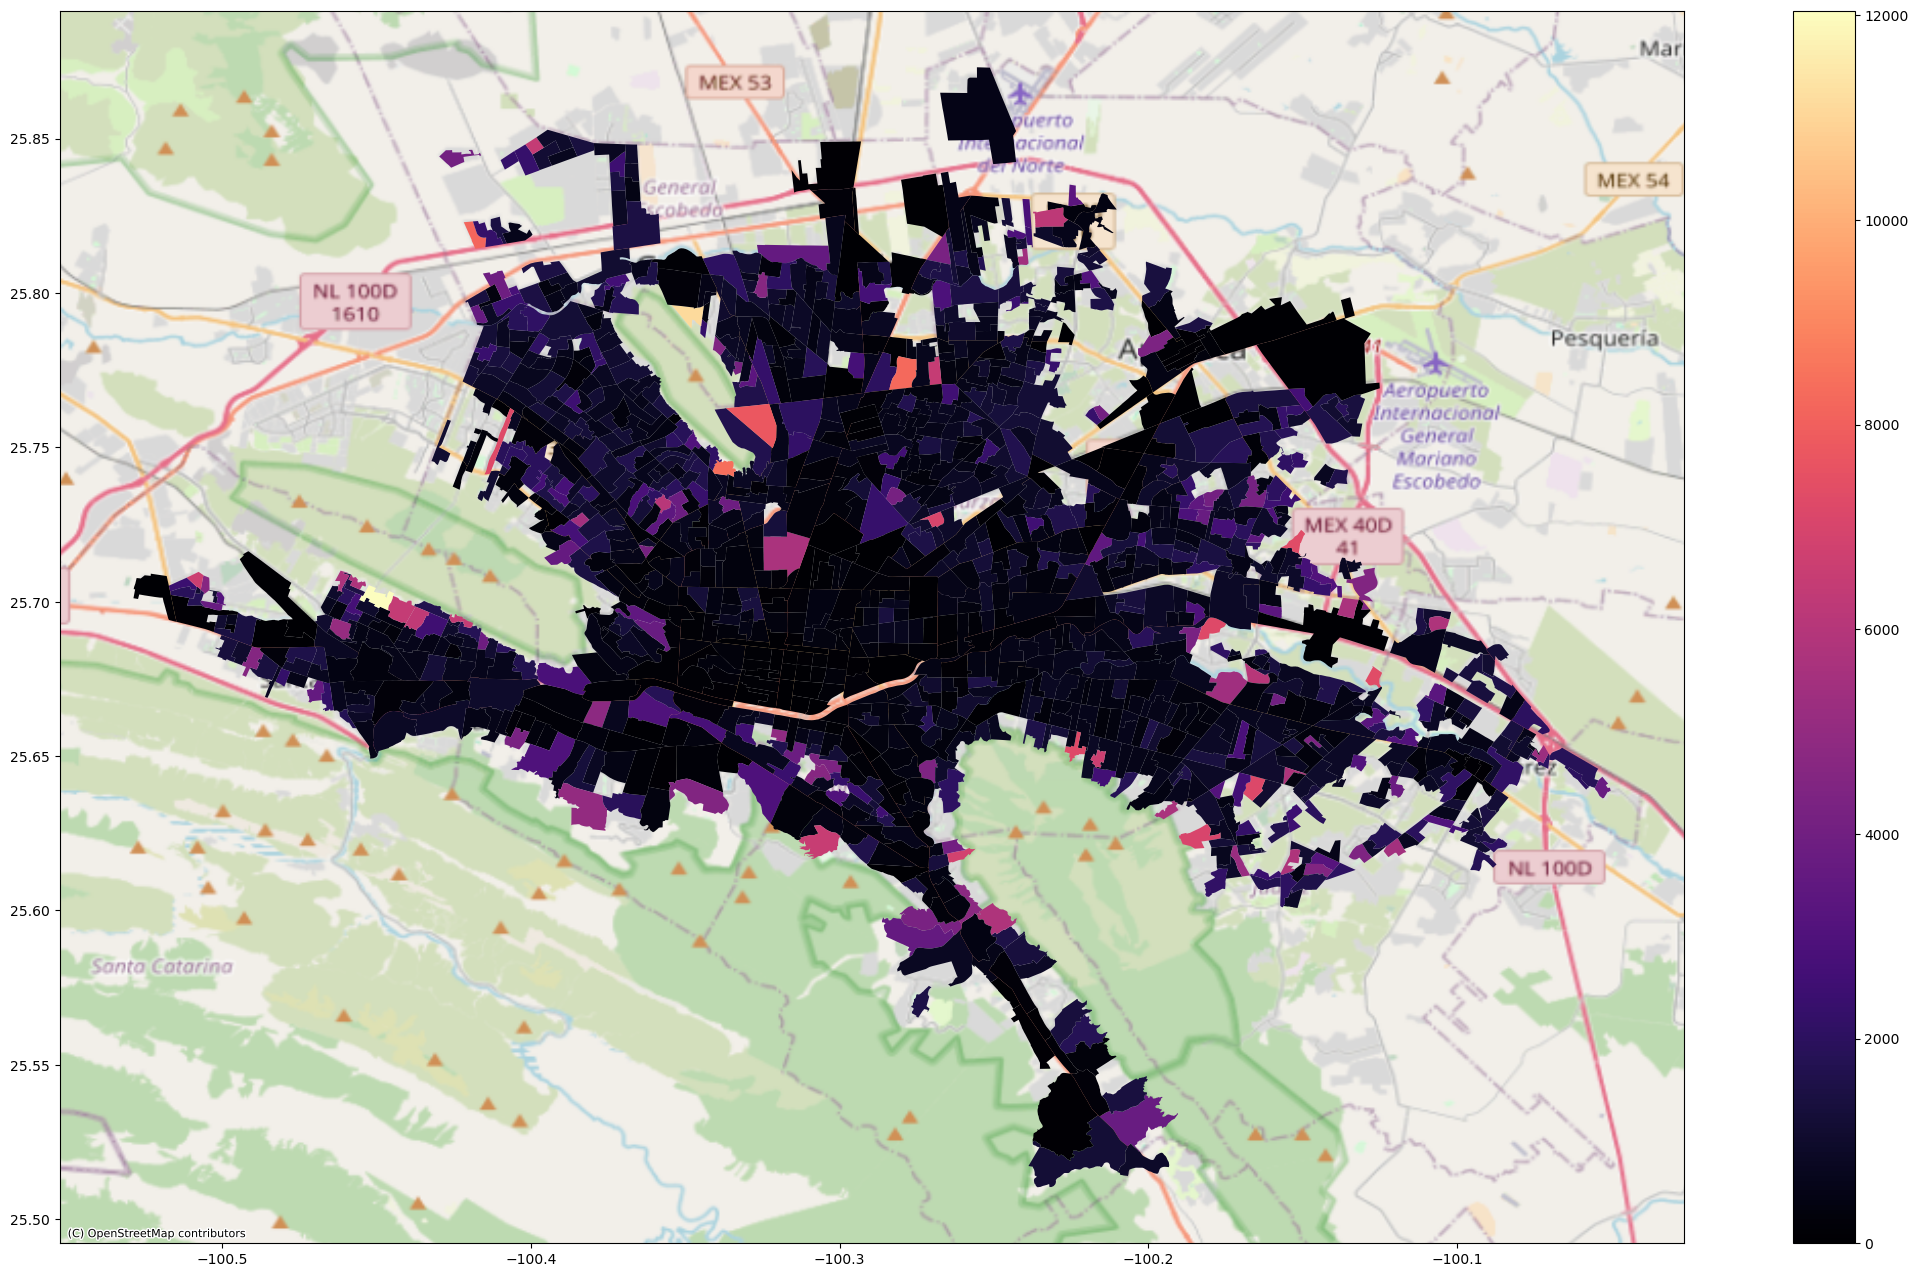

In [17]:
# Mostrar relación entre personas por restaurante en el mapa
ax = gdf.plot("POBREST", cmap="magma", legend=True, figsize=(28, 16))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

In [18]:
# Calcular la media y la desviación estándar de la columna
mean = gdf['POBREST'].mean()
std_dev = gdf['POBREST'].std()

In [19]:
# Definir límite basado en desviaciones estándar
cut_off = std_dev * 3
lower, upper = mean - cut_off, mean + cut_off

In [20]:
# Eliminar outliers
gdf_sin_outliers = gdf[(gdf['POBREST'] > lower) & (gdf['POBREST'] < upper)]

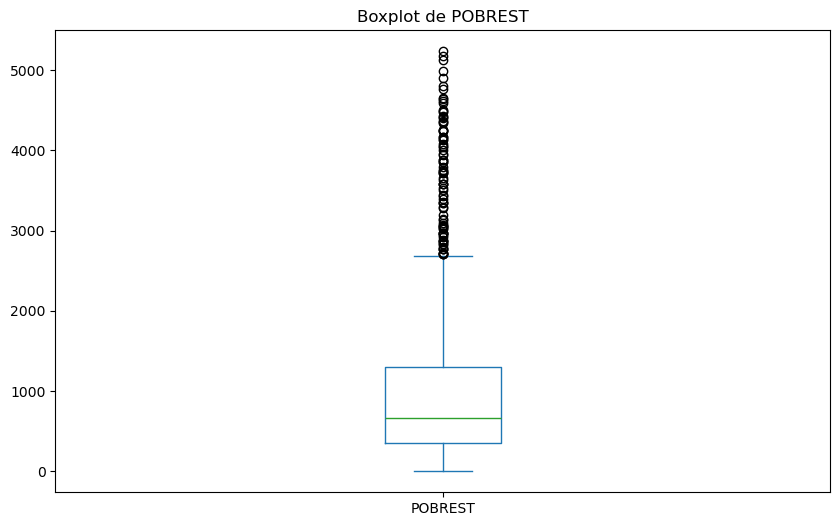

In [21]:
# Mostrar boxplot de POBREST
plt.figure(figsize=(10, 6))
gdf_sin_outliers['POBREST'].plot(kind='box')
plt.title(f"Boxplot de {'POBREST'}")
plt.show()

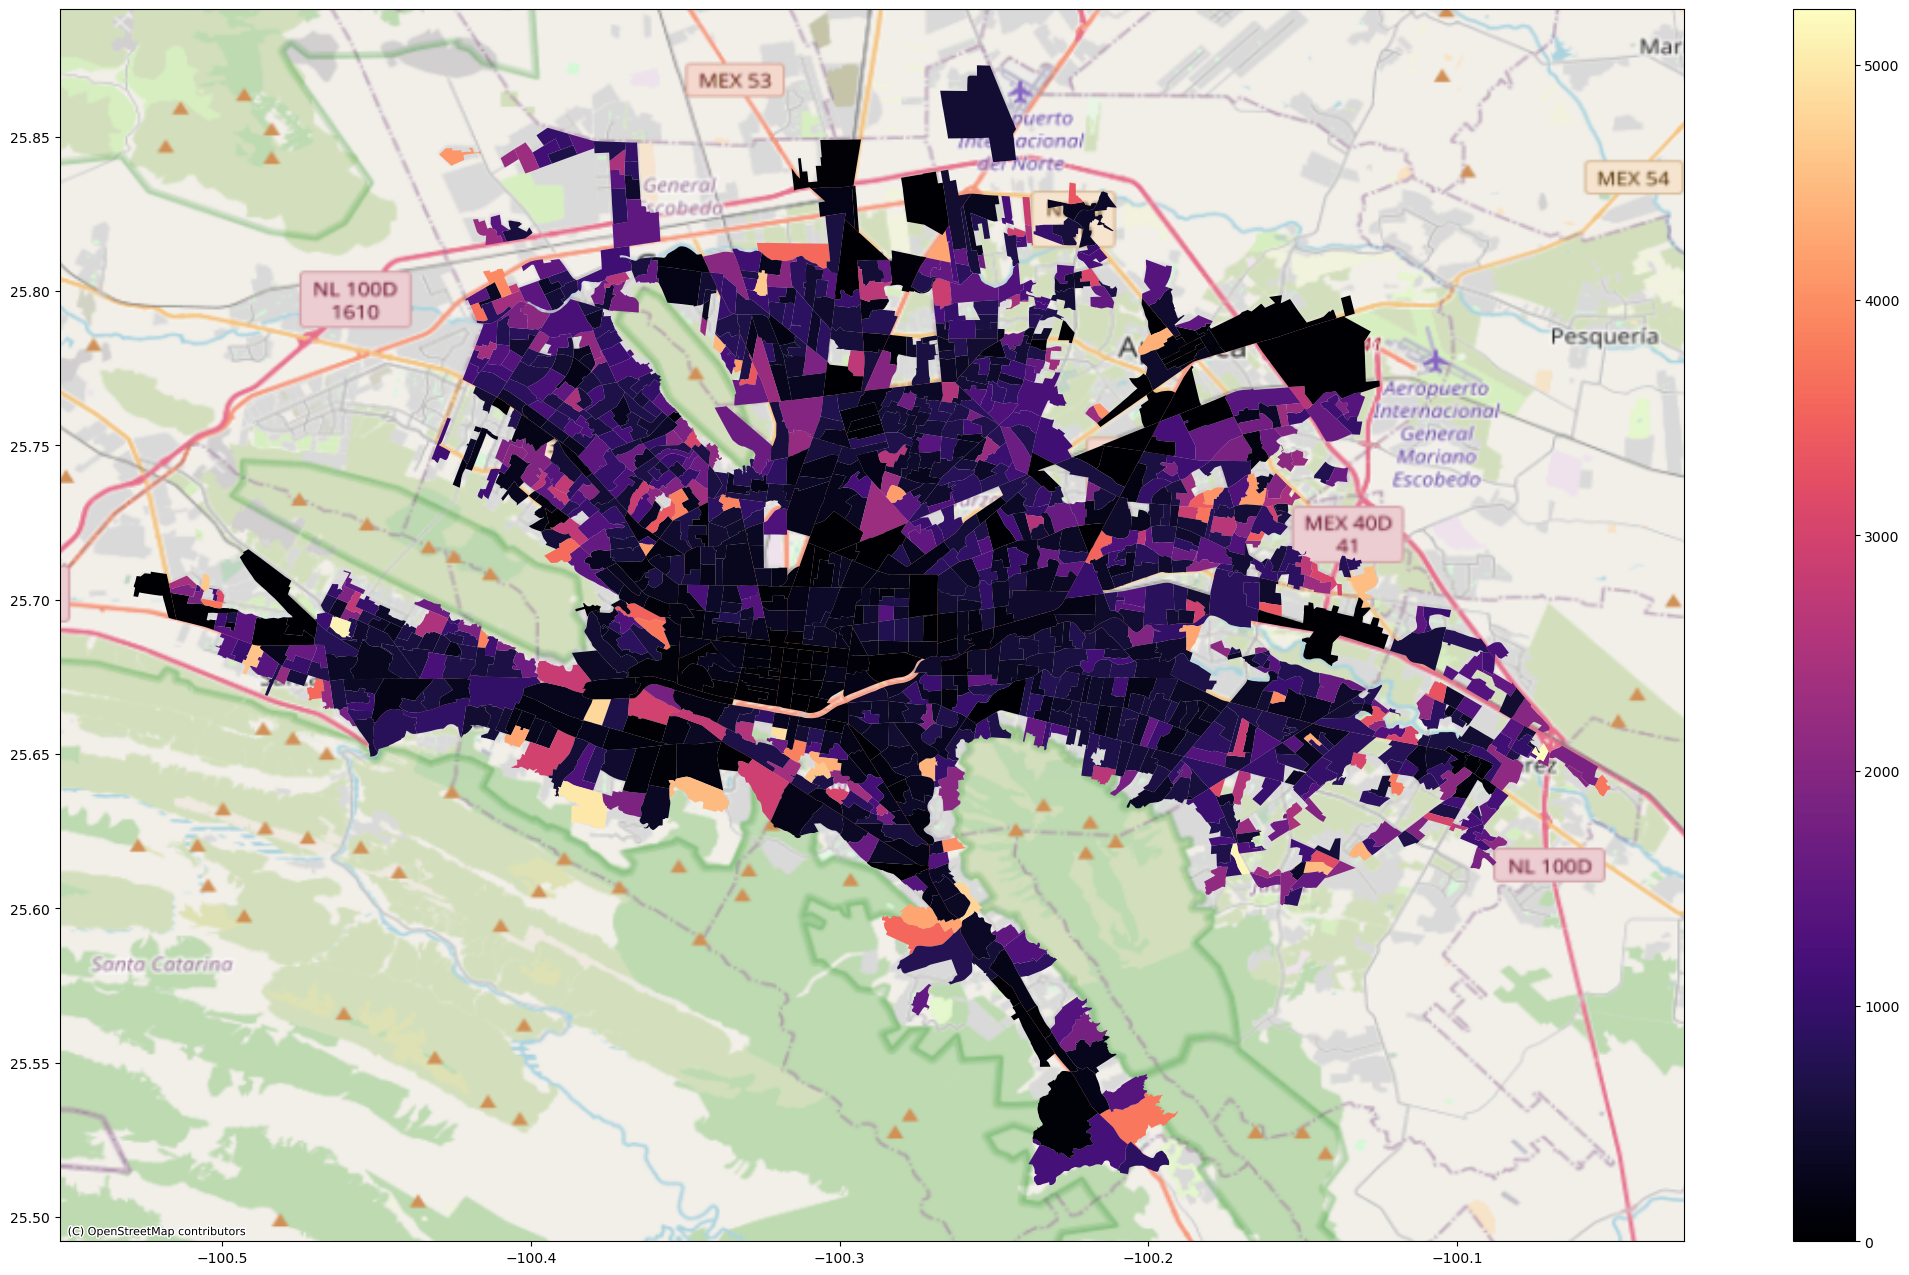

In [22]:
# Mostrar relación Pob Rest eliminando los outliers
ax = gdf_sin_outliers.plot("POBREST", cmap="magma", legend=True, figsize=(28, 16))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

In [23]:
# Conteo de clusters después de filtrar 
gdf_sin_outliers['Cluster'].value_counts()

Cluster
1    1111
3     131
2       6
Name: count, dtype: int64

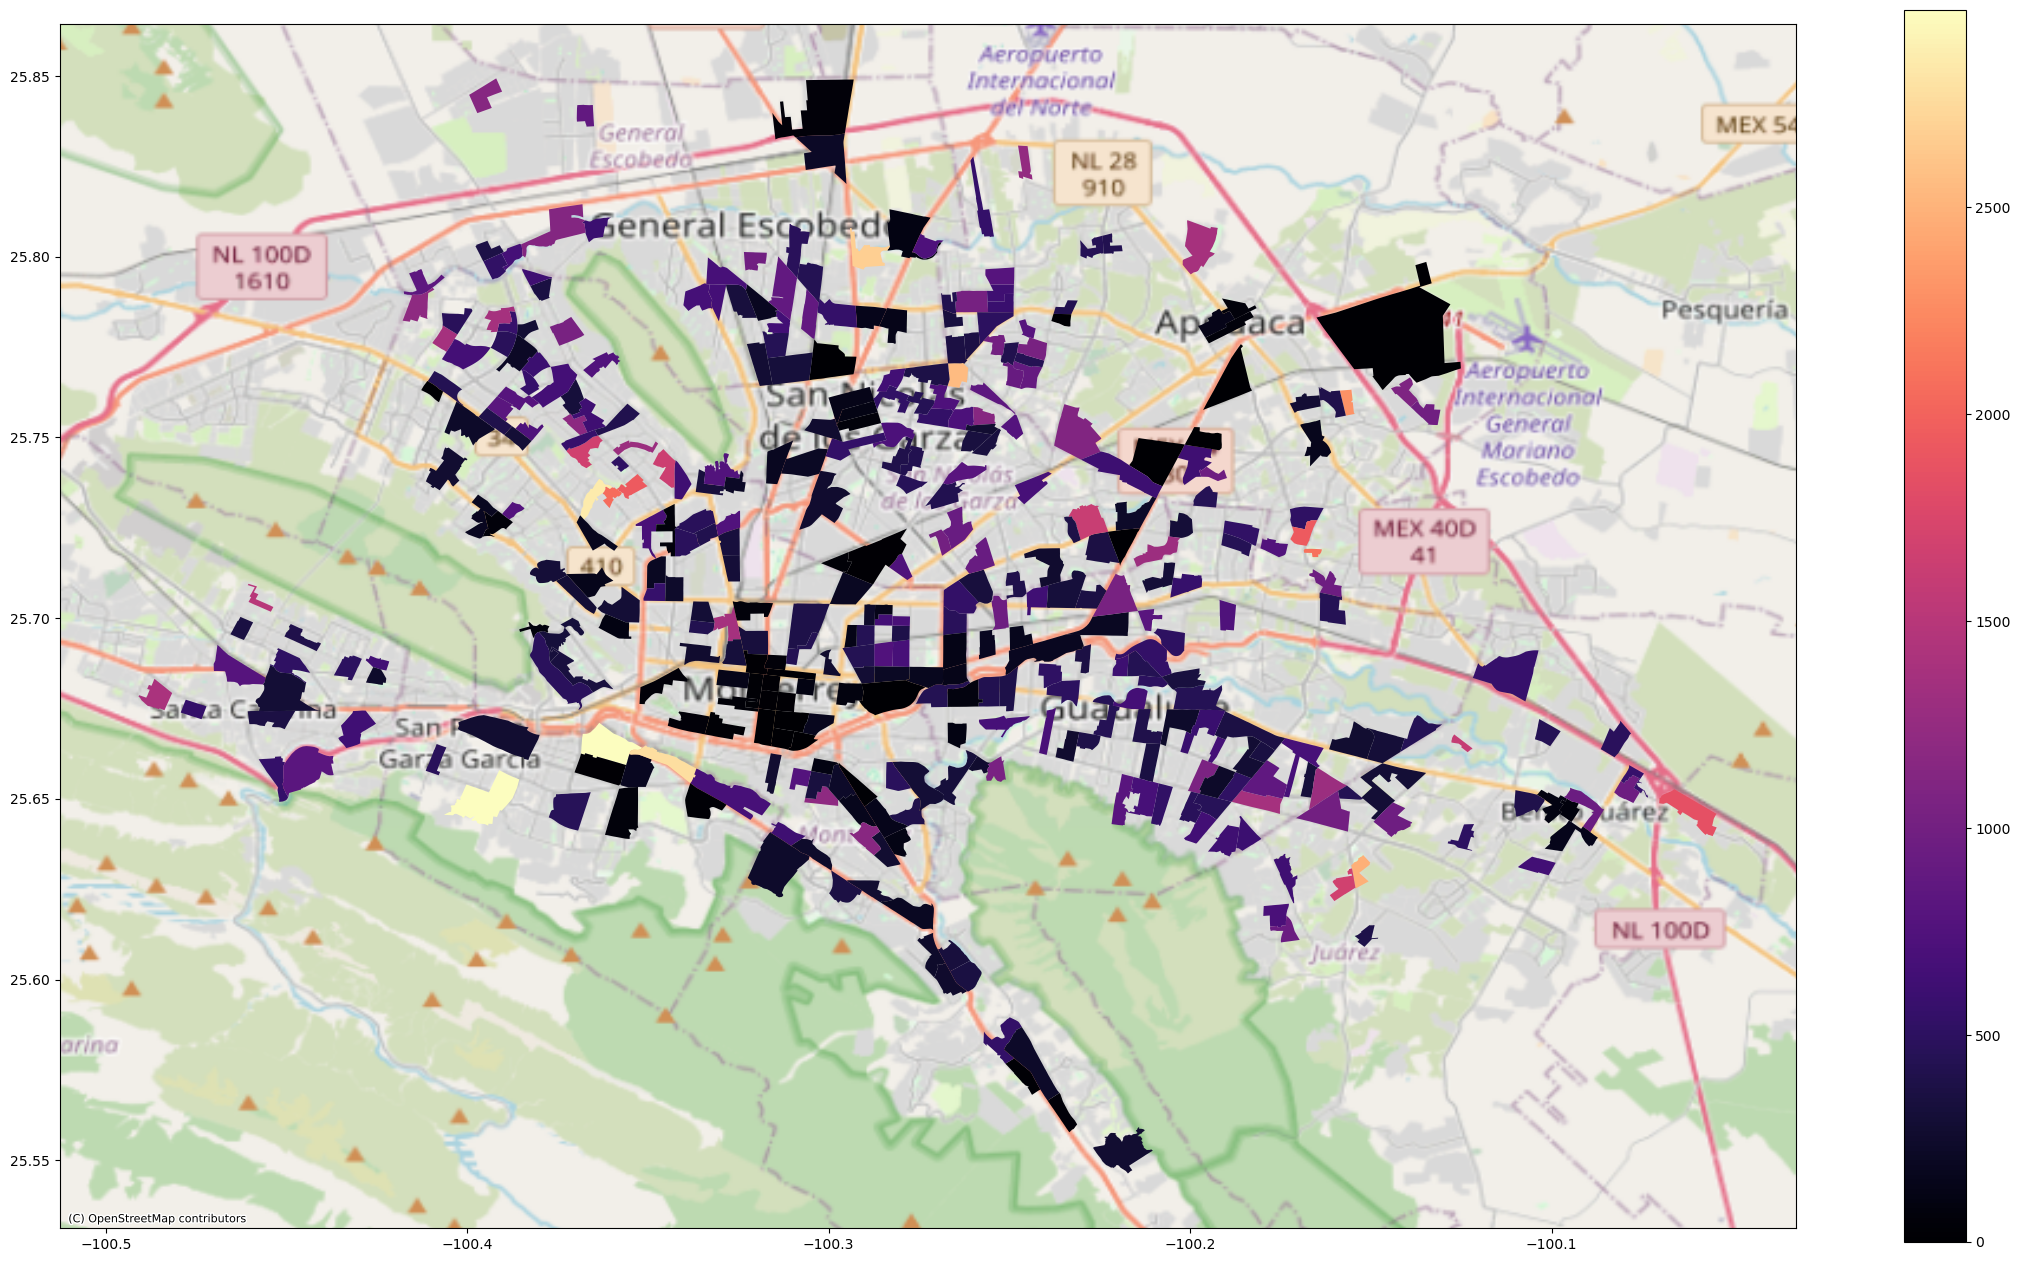

In [25]:
#Este solo considera los restaurantes de mariscos
# Calcular la media y la desviación estándar de la columna POBREST para el giro específico
mean_giro = gdf_giro_especifico['POBREST'].mean()
std_dev_giro = gdf_giro_especifico['POBREST'].std()

# Definir un límite basado en el número de desviaciones estándar
cut_off_giro = std_dev_giro * 3
lower_giro, upper_giro = mean_giro - cut_off_giro, mean_giro + cut_off_giro

# Filtrar outliers para el giro específico
gdf_giro_sin_outliers = gdf_giro_especifico[(gdf_giro_especifico['POBREST'] > lower_giro) & (gdf_giro_especifico['POBREST'] < upper_giro)]

# Crear mapa basado en el GeoDataFrame filtrado de outliers
ax = gdf_giro_sin_outliers.plot("POBREST", cmap="magma", legend=True, figsize=(28, 16))
cx.add_basemap(ax, crs=gdf_giro_sin_outliers.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Mostrar el mapa
plt.show()